<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import cv2

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

hello riyaz


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

<a id="data"></a>
# <center> DATA _mING AND PRE-PROCESSING</center>

Creating two different generator for train and test data

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [4]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 1266345 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


Category: Abuse


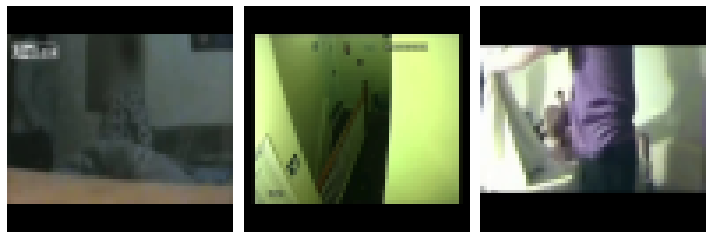

Category: Arrest


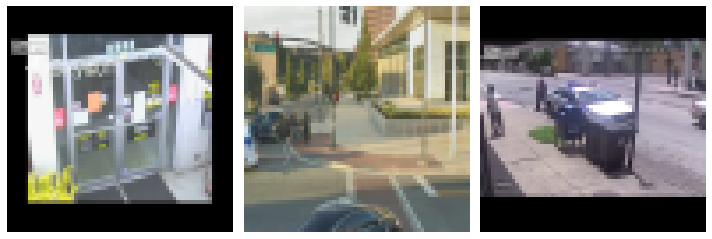

Category: Arson


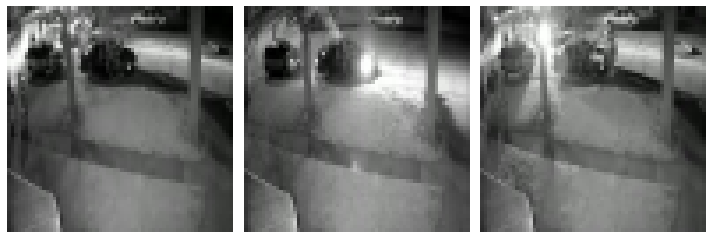

Category: Assault


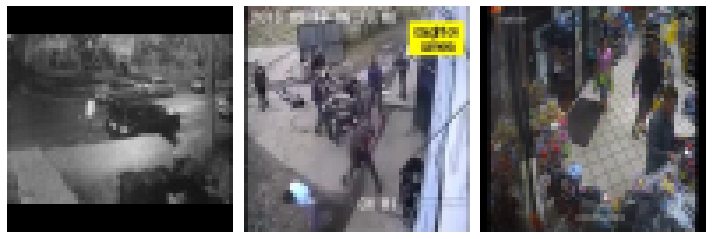

Category: Burglary


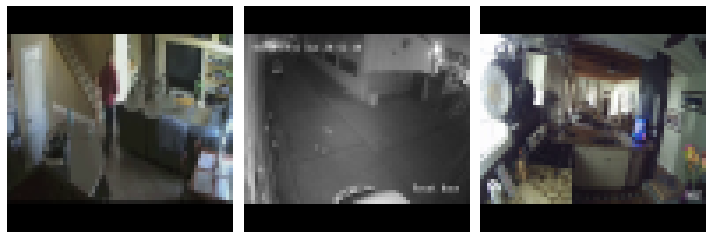

Category: Explosion


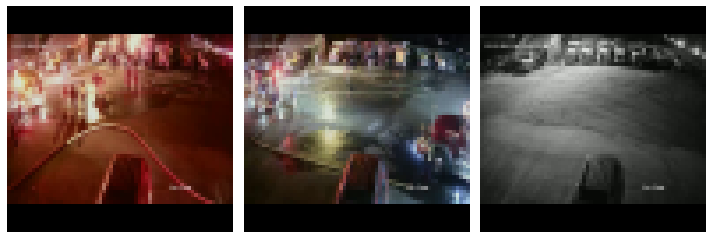

Category: Fighting


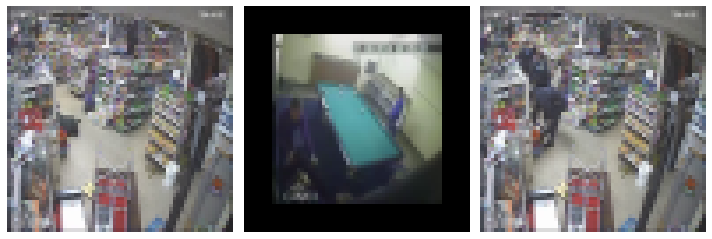

Category: NormalVideos


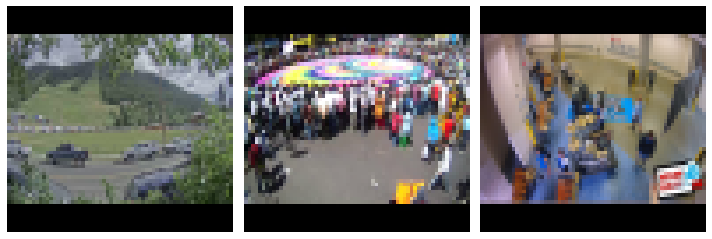

Category: RoadAccidents


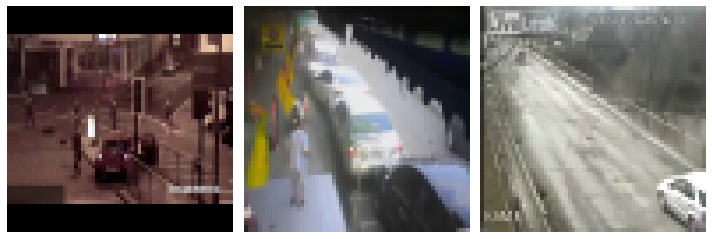

Category: Robbery


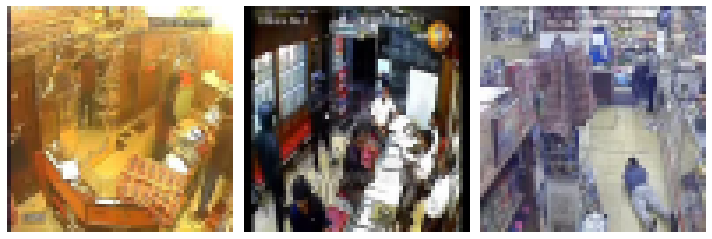

Category: Shooting


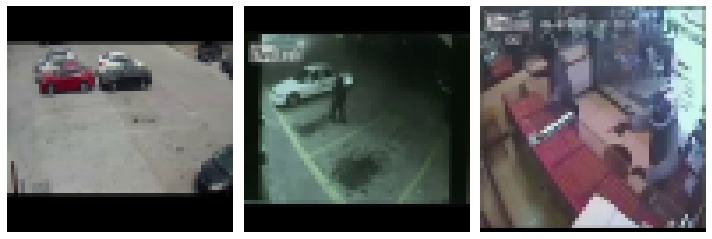

Category: Shoplifting


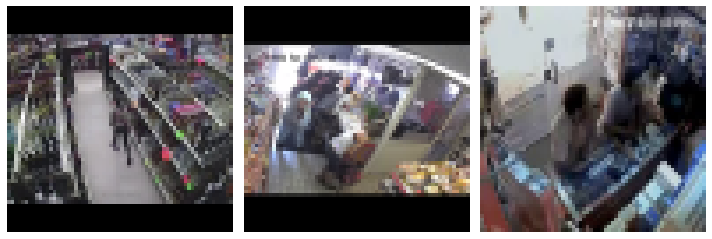

Category: Stealing


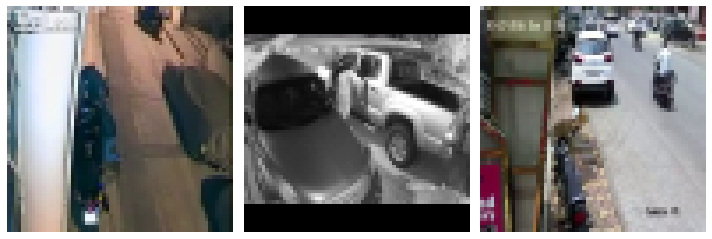

Category: Vandalism


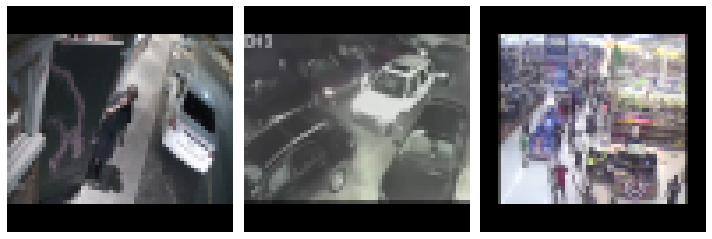

In [5]:

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Get the class indices and labels
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Display samples for each category
num_samples_per_category = 3  # Number of samples to display per category

for label in class_labels:
    print(f"Category: {label}")
    label_dir = os.path.join(train_dir, label)
    images = os.listdir(label_dir)[:num_samples_per_category]  # Get a few images from each category directory
    
    # Display the images
    plt.figure(figsize=(10, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(label_dir, img_name)
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Load image
        img = image.img_to_array(img) / 255.0  # Convert to array and normalize
        plt.subplot(1, num_samples_per_category, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


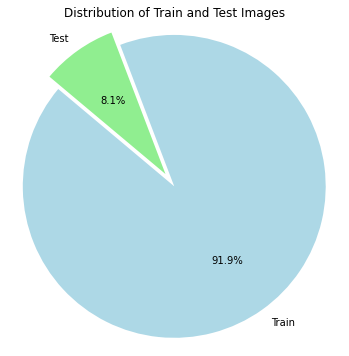

In [6]:


# Count the number of images in train and test directories
train_count = sum(len(files) for _, _, files in os.walk(train_dir))
test_count = sum(len(files) for _, _, files in os.walk(test_dir))

# Pie chart data
labels = ['Train', 'Test']
sizes = [train_count, test_count]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # explode the 1st slice (Train)

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Train and Test Images')
plt.show()


## Data distribution (count) among all the classes

### Train data Distribution

In [7]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Test Data Distribution

In [8]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet121 Transfer Learning  </center>

In [9]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = ['accuracy', tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

<a id="train"></a>
# <center> Training </center> 

In [10]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

 8752/19787 [============>.................] - ETA: 1:19:18 - loss: 1.4041 - accuracy: 0.6993 - auc: 0.8876

KeyboardInterrupt: 

<a id="auc"></a>
# <center> Accuracy and Multiclass AUC Curve </center> 

In [ ]:
preds = model.predict(test_generator)
y_test = test_generator.classes


In [ ]:
import pickle

In [ ]:
# with open("my_model.pkl", "wb") as f:
#     pickle.dump(model, f)

In [ ]:
model.save("CrimeExtract")

In [ ]:
# Save the model in TensorFlow 2.x
# tf.saved_model.save(model, "Crime")


In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [11]:
from tqdm import tqdm

In [12]:
test_dir = '/kaggle/input/ucf-crime-dataset/Test'
train_dir = '/kaggle/input/ucf-crime-dataset/Train'

# Define the categories and labels


In [13]:
categories_labels = {
    'Fighting': 6,
    'Shoplifting': 11,
    'Abuse': 0,
    'Arrest': 1,
    'Shooting': 10,
    'Robbery': 9,
    'Explosion': 5,
    'Arson': 2,
    'Assault': 3,
    'Burglary': 4,
    'Normal': 7,
    'RoadAccidents': 8,
    'Stealing': 12,
    'Vandalism': 13
}

In [14]:
import cv2

In [ ]:
def load_data(base_dir, categories_labels):
    data = []
    
    # Go through each category
    for category, label in categories_labels.items():
        # The path to the category directory
        category_dir = os.path.join(base_dir, category)

        # Make sure the directory exists
        if os.path.isdir(category_dir):
            # Go through each file in the directory
            for filename in tqdm(os.listdir(category_dir), desc=f"Loading {category}"):
                # Make sure the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    # The path to the image
                    image_path = os.path.join(category_dir, filename)

                    try:
                        # Load the image
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                        # Resize the image
                        image = cv2.resize(image, (50, 50))

                        # Reshape the image to 4D array (ImageDataGenerator requires 4D array)
                        image = image.reshape((1,) + image.shape + (1,))

                        # Add the image and its label to the data
                        data.append([image, label])
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")

    return data

# Load the training and test data
training_data = load_data(train_dir, categories_labels)
test_data = load_data(test_dir, categories_labels)

# Combine the training and test data
total_data = training_data + test_data

print(f"Loaded {len(total_data)} images.")

Loading Shooting:  32%|███▏      | 2432/7630 [00:11<00:25, 207.48it/s]

In [ ]:
images_lstm[0].shape, images.shape, train_images_cnn.shape

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import time


# Initialize lists to store the images and the labels
images = []
labels = []

# Go through each image and its label in the total_data
for image, label in total_data:
    images.append(image)
    labels.append(label)

# Convert the lists into numpy arrays
images = np.array(images)
labels = np.array(labels)
print(images.shape)

# Reshape images for LSTM
images_lstm = images.reshape(images.shape[0], -1, 1)  # Added third dimension for features

# Set a seed for reproducibility
seed = 42

# Split the data into training and testing sets for CNN
train_images_cnn, test_images_cnn, train_labels_cnn, test_labels_cnn = train_test_split(images, labels, test_size=0.1, random_state=seed)

# Split the data into training and testing sets for LSTM
train_images_lstm, test_images_lstm, train_labels_lstm, test_labels_lstm = train_test_split(images_lstm, labels, test_size=0.1, random_state=seed)

# Convert labels to categorical for CNN
train_labels_cnn = np_utils.to_categorical(train_labels_cnn, len(categories_labels))
test_labels_cnn = np_utils.to_categorical(test_labels_cnn, len(categories_labels))

# Convert labels to categorical for LSTM
train_labels_lstm = np_utils.to_categorical(train_labels_lstm, len(categories_labels))
test_labels_lstm = np_utils.to_categorical(test_labels_lstm, len(categories_labels))

# Remove the second dimension from your data
train_images_cnn = np.squeeze(train_images_cnn, axis=1)
test_images_cnn = np.squeeze(test_images_cnn, axis=1)


# CNN Model
model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(50, 50, 1)))
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D((2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(128, (3, 3), padding='same')) 
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(256, (3, 3), padding='same'))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
model_CNN.add(Dropout(0.4))  
model_CNN.add(Flatten()) 
model_CNN.add(Dense(256)) 
model_CNN.add(LeakyReLU(alpha=0.1))            
model_CNN.add(Dropout(0.5)) 

# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units = 8, return_sequences = True, input_shape = (2500, 1), activation='tanh'))
model_lstm.add(LSTM(units = 8, return_sequences = True))
model_lstm.add(Dense(4, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Flatten())

# Combine CNN and LSTM model
nb_classes = 14
combined = concatenate([model_CNN.output, model_lstm.output], axis=-1)
output = Dense(nb_classes, activation='softmax')(combined)
model_final = Model(inputs=[model_CNN.input, model_lstm.input], outputs=output)

# Plot and compile the model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
mc = ModelCheckpoint('CNN_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Training
time1 = time.time()
history = model_final.fit([train_images_cnn, train_images_lstm], train_labels_lstm, batch_size=1000, epochs=20, validation_data=([test_images_cnn, test_images_lstm], test_labels_lstm), callbacks=[mc, csv_logger])
print (("Training time=", time.time()-time1))

# Save training history
np.save("CNN_LSTM_history.npy", history.history)

# from keras.models import load_model


In [ ]:
fashion_model = load_model('./CNN_LSTM.h5') # load model
fashion_model.summary() # summarize model.

from contextlib import redirect_stdout
with open('./CNN_LSTM'+".xls", 'w') as f:
    with redirect_stdout(f):
        fashion_model.summary()
        
val_loss, val_accuracy=fashion_model.evaluate([test_images_cnn, test_images_lstm] ,test_labels_cnn) ## to get test accuracy and losses
print(val_loss, val_accuracy)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
test_images_cnn[0]

In [ ]:
time2=time.time()
predict_prob=fashion_model.predict([test_images_cnn, test_images_lstm])
y_pred=np.argmax(predict_prob,axis=1)
print ('classification time:', time.time()-time2)

##print (y_pred)
y_true=np.argmax(test_labels_cnn, axis=1)
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print (cm)
print(classification_report(y_true, y_pred))

precision = precision_score(y_true, y_pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred, average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 score: %f' % f1)
#-----------  IoU
from sklearn.metrics import jaccard_score
print ('IoU:', jaccard_score(y_true, y_pred, average='micro'))


test_eval = fashion_model.evaluate([test_images_cnn, test_images_lstm], test_labels_cnn)

loss, accuracy = fashion_model.evaluate([train_images_cnn, train_images_lstm], train_labels_cnn)
print('loss_train: ', loss, 'accuracy_train: ', accuracy)
print('Test loss:', test_eval[0], 'Test accuracy:', test_eval[1])

In [ ]:
import matplotlib.pyplot as plt

history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1, len(acc_values)+1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
loss_values=smooth_curve(loss_values)
val_loss_values=smooth_curve(val_loss_values)
acc_values=smooth_curve(acc_values)
val_acc_values=smooth_curve(val_acc_values)

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12}
        

plt.plot(epochs, acc_values, 'r-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.title('Training and Validation acc', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.legend()
plt.savefig("accuracy"+'CNN_LSTM'+".png")
plt.show()

plt.plot(epochs, loss_values, 'b-', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation loss', fontdict=font)
plt.xlabel('Epochs',fontdict=font)
plt.ylabel('Loss',fontdict=font)
plt.legend()
plt.savefig("loss"+'CNN_LSTM'+".png")
plt.show()


In [ ]:
categories_labels = {
    'Fighting': 6,
    'Shoplifting': 11,
    'Abuse': 0,
    'Arrest': 1,
    'Shooting': 10,
    'Robbery': 9,
    'Explosion': 5,
    'Arson': 2,
    'Assault': 3,
    'Burglary': 4,
    'Normal': 7,
    'RoadAccidents': 8,
    'Stealing': 12,
    'Vandalism': 13
}

In [ ]:
# class_names = ['Fighting', 'Shoplifting', 'Abuse', 'Arrest', 'Shooting', 'Robbery', 'Explosion',]
class_names = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 14}

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion matrix1'+'CNN_LSTM'+'.png')
plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion matrix2'+'CNN_LSTM'+'.png')
plt.show()

In [ ]:
model_json = model_final.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the weights of the model
model_final.save_weights("model_weights.h5")

In [ ]:
def extract_and_process_frames(video_path):
    """
    Extracts every 10th frame from the given video file, converts each frame to grayscale,
    resizes it to 50x50 pixels, and returns them in a NumPy array.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    - A NumPy array containing processed frames of shape (50, 50, 1).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Error opening video file {video_path}")

    frames = []  # To hold the processed frames
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        if frame_count % 15 == 0:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            resized_frame = cv2.resize(gray_frame, (50, 50))  # Resize the frame
            frames.append(resized_frame.reshape(50, 50, 1))  # Add an extra dimension for consistency with the requested shape
        
        frame_count += 1

    cap.release()

    return np.array(frames)

In [ ]:
video_path = '/kaggle/input/dcsass-videos/processed DCSASS Dataset/Burglary/Burglary035.mp4'
frames = extract_and_process_frames(video_path)

In [ ]:
print(f"Extracted {frames.shape[0]} frames, each of shape {frames.shape[1:]}.")
frame_0 = frames[0].reshape(-1, 1)
print(frame_0.shape, frames[0].shape)
frames_lstm = frames.reshape(frames.shape[0], -1, 1) 

In [ ]:
test_prob=fashion_model.predict([frames, frames_lstm])
y_pred=np.argmax(test_prob,axis=1)

In [ ]:
categories_labels = {
    'Fighting': 6,
    'Shoplifting': 11,
    'Abuse': 0,
    'Arrest': 1,
    'Shooting': 10,
    'Robbery': 9,
    'Explosion': 5,
    'Arson': 2,
    'Assault': 3,
    'Burglary': 4,
    'Normal': 7,
    'RoadAccidents': 8,
    'Stealing': 12,
    'Vandalism': 13
}

reverse_categories_labels = {v: k for k, v in categories_labels.items()}


In [ ]:
for i in y_pred:
    print(reverse_categories_labels[i])